In [ ]:
import os
import numpy  as np
import warnings
warnings.filterwarnings("ignore")

import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install tensorflow

### Plot of random images from the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


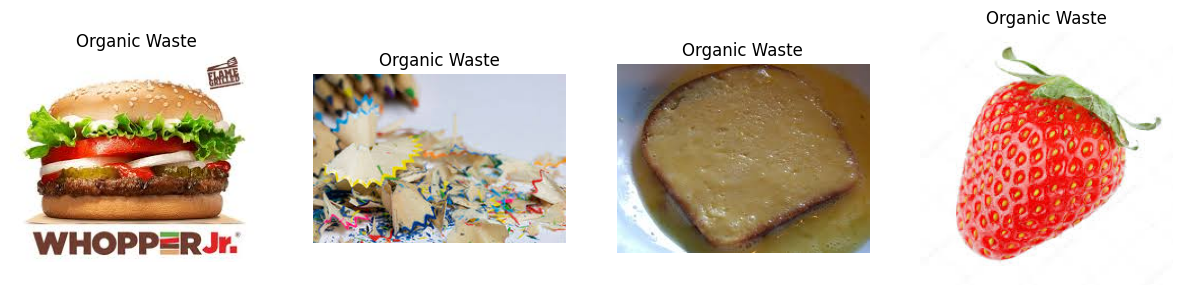

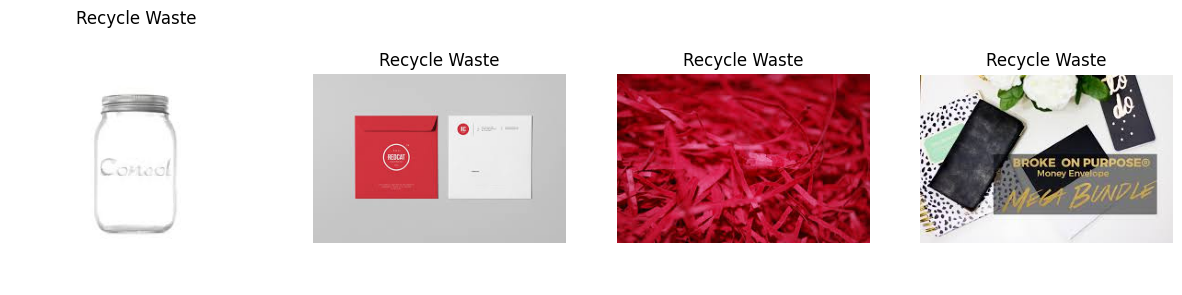

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define the function to plot random images
def plot_random_images(dataset_dir, category, num_images=4):
    # Path to the specified category directory
    category_dir = os.path.join(dataset_dir, category)

    # Get the list of image file names in the category directory
    image_files = os.listdir(category_dir)

    # Check if there are enough images to sample from
    if len(image_files) == 0:
        print("Error: No images found in the category directory.")
        return
    elif len(image_files) < num_images:
        print("Error: Not enough images in the category directory.")
        return

    # Select num_images random images from the category directory
    random_images = random.sample(image_files, num_images)

    # Plot the random images
    plt.figure(figsize=(15, 5))  # Set the size of the figure
    for i, image_name in enumerate(random_images):
        # Load the image
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)

        # Plot the image
        plt.subplot(1, num_images, i+1)  # Create a subplot for each image
        plt.imshow(image)  # Display the image
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")  # Set the title for each image
        plt.axis('off')  # Turn off the axis

    plt.show()  # Display the plot containing the random images

# Update directories
dataset_directory = '/content/drive/MyDrive/Colab Notebooks/DATASET/TRAIN'

# Example usage
plot_random_images(dataset_directory, 'O', num_images=4)  # Plot random images from 'O' category
plot_random_images(dataset_directory, 'R', num_images=4)  # Plot random images from 'R' category


In [ ]:
# Update directories
train_directory = '/content/drive/MyDrive/Colab Notebooks/DATASET/TRAIN'
test_directory = '/content/drive/MyDrive/Colab Notebooks/DATASET/TEST'

In [ ]:
train_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)

test_data_generator = ImageDataGenerator(
    #rescale = 1./255,
    preprocessing_function=preprocess_input
)

In [ ]:
train_generator = train_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="training",
    seed = 43
)

Found 18052 images belonging to 2 classes.


In [ ]:
validation_generator = validation_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="validation",
    seed = 43
)

Found 4512 images belonging to 2 classes.


In [ ]:
test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True
)

Found 2513 images belonging to 2 classes.


In [ ]:
# Define the core VGG16 model with pre-trained weights
core = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
core.trainable = False

# Define the sequential model
model = Sequential([
    core,
    Flatten(),
    Dense(100, activation="relu"),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Define early stopping callback
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

# Define model checkpoint callback based on validation accuracy
checkpoint_path = "model_checkpoint.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[earlystopping, checkpoint])

Epoch 1/15
142/142 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.8427 
Epoch 1: val_accuracy improved from -inf to 0.91600, saving model to model_checkpoint.keras
142/142 [==============================] - 2902s 21s/step - loss: 0.7636 - accuracy: 0.8427 - val_loss: 0.2168 - val_accuracy: 0.9160
Epoch 2/15
142/142 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8931
Epoch 2: val_accuracy improved from 0.91600 to 0.92575, saving model to model_checkpoint.keras
142/142 [==============================] - 140s 987ms/step - loss: 0.2995 - accuracy: 0.8931 - val_loss: 0.2073 - val_accuracy: 0.9258
Epoch 3/15
141/142 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.9050
Epoch 3: val_accuracy improved from 0.92575 to 0.93218, saving model to model_checkpoint.keras
142/142 [==============================] - 140s 983ms/step - loss: 0.2540 - accuracy: 0.9049 - val_loss: 0.1941 - val_accuracy: 0.9322
Epoch 4/15
142/142 [=====

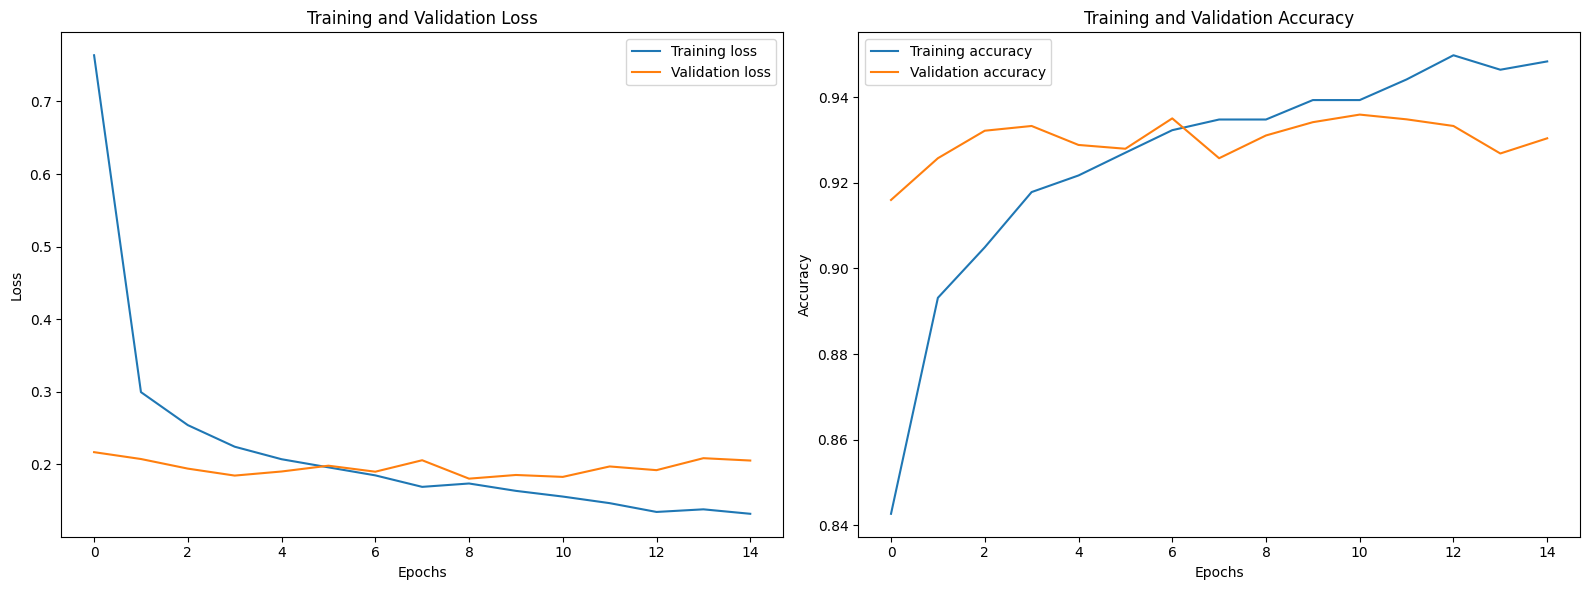

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(12, 5)):
    """
    Plot training and validation metrics over epochs.

    Parameters:
        history (History): History object returned by model.fit().
        metrics (list): List of metrics to plot (e.g., ['loss', 'accuracy']).
        figsize (tuple): Figure size (width, height) in inches.

    Returns:
        None
    """
    # Create subplots based on the number of metrics
    num_metrics = len(metrics)
    plt.figure(figsize=figsize)

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, i)
        plt.plot(history.epoch, history.history[metric], label='Training ' + metric)
        plt.plot(history.epoch, history.history['val_' + metric], label='Validation ' + metric)
        plt.title('Training and Validation ' + metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'history' contains the training history object
plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(16, 6))


In [ ]:
evaluation = model.evaluate(test_generator)
print(f'test Loss: {evaluation[0]:.4f}')
print(f'test Accuracy: {evaluation[1] * 100:.2f}%')

20/20 [==============================] - 788s 41s/step - loss: 0.3588 - accuracy: 0.9021
test Loss: 0.3588
test Accuracy: 90.21%


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               819300    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [ ]:
%pip install -q "openvino-dev>=2024.0.0"
%pip install -q tensorflow
%pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

('notebook_utils.py', <http.client.HTTPMessage at 0x79ace93e1d50>)

In [ ]:
import collections
import tarfile
import time
from pathlib import Path

import cv2
import numpy as np
from IPython import display
import openvino as ov
from openvino.tools.mo.front import tf as ov_tf_front
from openvino.tools import mo

import notebook_utils as utils

In [ ]:
# A directory where the model will be downloaded.
base_model_dir = Path("model1")

# The name of the model from Open Model Zoo
model_name = "ssdlite_mobilenet_v2"

archive_name = Path(f"{model_name}_coco_2018_05_09.tar.gz")
model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/public/2022.1/{model_name}/{archive_name}"

# Download the archive
downloaded_model_path = base_model_dir / archive_name
if not downloaded_model_path.exists():
    utils.download_file(model_url, downloaded_model_path.name, downloaded_model_path.parent)

# Unpack the model
tf_model_path = base_model_dir / archive_name.with_suffix("").stem / "frozen_inference_graph.pb"
if not tf_model_path.exists():
    with tarfile.open(downloaded_model_path) as file:
        file.extractall(base_model_dir)

In [ ]:
precision = "FP16"
# The output path for the conversion.
converted_model_path = Path("model1") / f"{model_name}_{precision.lower()}.xml"

# Convert it to IR if not previously converted
trans_config_path = Path(ov_tf_front.__file__).parent / "ssd_v2_support.json"
if not converted_model_path.exists():
    ov_model = mo.convert_model(
        tf_model_path,
        compress_to_fp16=(precision == 'FP16'),
        transformations_config=trans_config_path,
        tensorflow_object_detection_api_pipeline_config=tf_model_path.parent / "pipeline.config",
        reverse_input_channels=True
    )
    ov.save_model(ov_model, converted_model_path)
    del ov_model

In [ ]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device


Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
# Read the network and corresponding weights from a file.
model = core.read_model(model=converted_model_path)
# Compile the model for CPU (you can choose manually CPU, GPU etc.)
# or let the engine choose the best available device (AUTO).
compiled_model = core.compile_model(model=model, device_name=device.value)

# Get the input and output nodes.
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# Get the input size.
height, width = list(input_layer.shape)[1:3]

In [ ]:
input_layer.any_name, output_layer.any_name


('image_tensor:0', 'detection_boxes:0')

In [ ]:
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
classes = [
    "background", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe", "eye glasses",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "plate", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "mirror", "dining table", "window", "desk", "toilet",
    "door", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]

# Colors for the classes above (Rainbow Color Map).
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()


def process_results(frame, results, thresh=0.6):
    # The size of the original frame.
    h, w = frame.shape[:2]
    # The 'results' variable is a [1, 1, 100, 7] tensor.
    results = results.squeeze()
    boxes = []
    labels = []
    scores = []
    for _, label, score, xmin, ymin, xmax, ymax in results:
        # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
        boxes.append(
            tuple(map(int, (xmin * w, ymin * h, (xmax - xmin) * w, (ymax - ymin) * h)))
        )
        labels.append(int(label))
        scores.append(float(score))

    # Apply non-maximum suppression to get rid of many overlapping entities.
    # See https://paperswithcode.com/method/non-maximum-suppression
    # This algorithm returns indices of objects to keep.
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=thresh, nms_threshold=0.6
    )

    # If there are no boxes.
    if len(indices) == 0:
        return []

    # Filter detected objects.
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]


organic_items = [
    "person", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant",
    "bear", "zebra", "giraffe", "hat", "backpack", "umbrella", "shoe",
    "eye glasses", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "banana", "apple", "sandwich", "orange", "broccoli", "carrot",
    "hot dog", "pizza", "donut", "cake",  "potted plant"
]

recycled_items = [
    "background", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "street sign", "stop sign",
    "parking meter", "bench", "bottle", "plate", "wine glass", "cup", "fork",
    "knife", "spoon", "bowl", "chair", "couch", "bed",
    "mirror", "dining table", "window", "desk", "toilet", "door", "tv", "laptop",
    "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster",
    "sink", "refrigerator", "blender", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush", "hair brush"
]


def draw_boxes(frame, boxes):
    for label, score, box in boxes:
        # Choose color for the label.
        color = tuple(map(int, colors[label]))
        # Draw a box.
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]
        cv2.rectangle(img=frame, pt1=box[:2], pt2=(x2, y2), color=color, thickness=3)

        # Determine if the object is organic or recycled based on the label
        if classes[label] in organic_items:
            classification = "(Organic)"
        elif classes[label] in recycled_items:
            classification = "(Recycled)"
        else:
            classification = "(Unknown)"

        # Draw a label name inside the box.
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f} {classification}",
            org=(box[0] + 10, box[1] + 30),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame.shape[1] / 1000,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

    return frame


    return frame

In [ ]:
# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Resize the image and change dims to fit neural network input.
            input_img = cv2.resize(
                src=frame, dsize=(width, height), interpolation=cv2.INTER_AREA
            )
            # Create a batch of images (size = 1).
            input_img = input_img[np.newaxis, ...]

            # Measure processing time.

            start_time = time.time()
            # Get the results.
            results = compiled_model([input_img])[output_layer]
            stop_time = time.time()
            # Get poses from network results.
            boxes = process_results(frame=frame, results=results)

            # Draw boxes on a frame.
            frame = draw_boxes(frame=frame, boxes=boxes)

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

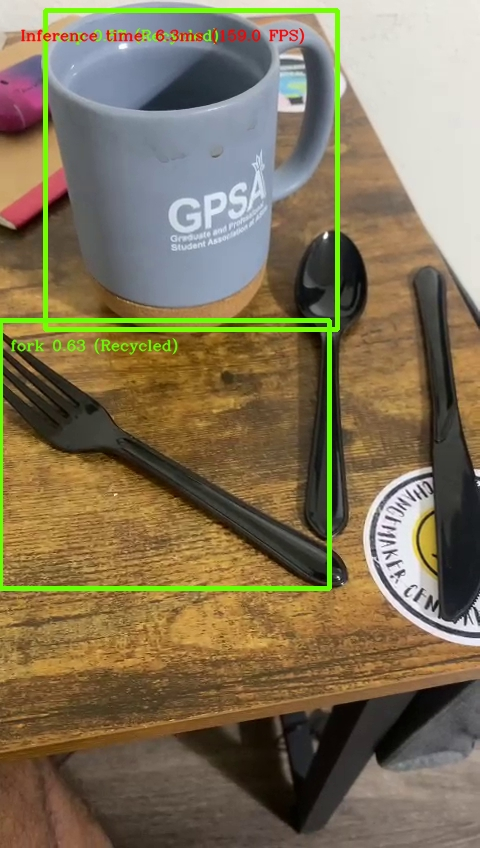

Source ended


In [ ]:
USE_WEBCAM = False

video_file = "/content/drive/MyDrive/Colab Notebooks/Images/aabbddcc.mp4"
cam_id = 0

source = cam_id if USE_WEBCAM else video_file

run_object_detection(source=source, flip=isinstance(source, int), use_popup=False)

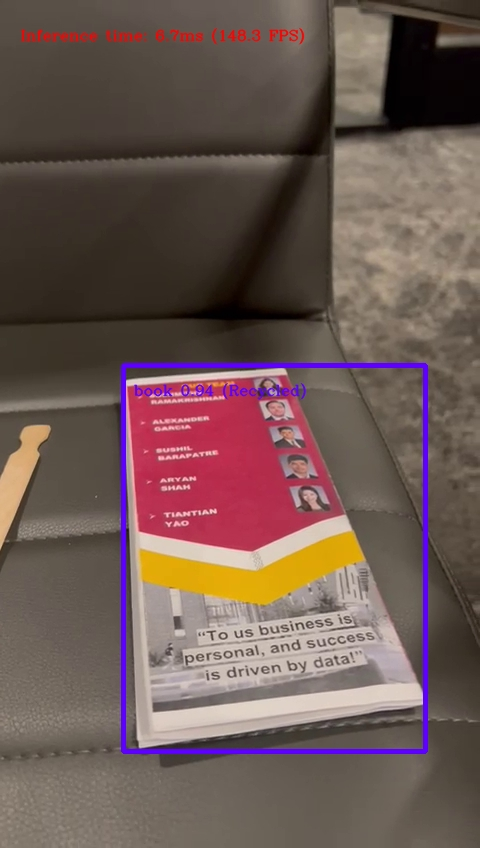

Source ended


In [ ]:
USE_WEBCAM = False

video_file = "/content/drive/MyDrive/Colab Notebooks/Images/FINALDEMO.mp4"
cam_id = 0

source = cam_id if USE_WEBCAM else video_file

run_object_detection(source=source, flip=isinstance(source, int), use_popup=False)

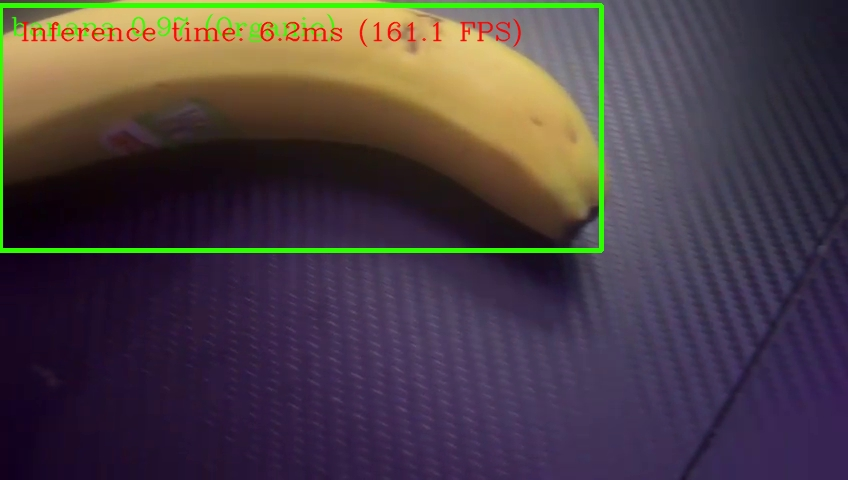

In [ ]:
USE_WEBCAM = False

video_file = "/content/drive/MyDrive/Colab Notebooks/Images/finaldemo3.mp4"
cam_id = 0

source = cam_id if USE_WEBCAM else video_file

run_object_detection(source=source, flip=isinstance(source, int), use_popup=False)